In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="FixedFormatter should only be used together")

# Reading answers from google sheet

In [7]:
# Read raw Excel sheet
rawData = pd.read_csv('data/Survey_2.0.csv', delimiter=';')
rawData['Timestamp'] = pd.to_datetime(rawData['Timestamp'], format='%d.%m.%Y %H:%M:%S')
rawData = rawData[(rawData['Timestamp'] > pd.to_datetime('01.11.2022', format='%d.%m.%Y')) 
                    & (rawData['Timestamp'] < pd.to_datetime('31.05.2023', format='%d.%m.%Y'))]

# additional data about SciFinder were paste manually from 413_ to 413 row
rawData = rawData[rawData['Please enter your data barcode'] != '413_']

# Fix TargetMol Name
rawData.rename(columns=
        {'What did you like the on each site? [Targetmol]':'What did you like the on each site? [TargetMol]',
        'What did you NOT like the on each site? [Targetmol]': 'What did you NOT like the on each site? [TargetMol]',}, 
        inplace=True)


database_classification={'ChEMBL':'Academia','Guide to Pharmacology':'Academia','Probes and Drugs':'Academia',
                        'DrugBank':'Academia','TargetMol':'Vendor','MedChemExpress':'Vendor',
                        'SelleckChem':'Vendor','Toronto Research Chemicals':'Vendor',
                        'Tocris':'Vendor','Cayman':'Vendor','Santa Cruz':'Vendor',
                        'Reaxys':'Closed','SciFinder':'Closed'}


participants = [p for p in rawData['Please enter your data barcode'].to_list()]
compounds = ['[Compound 1]','[Compound 2]','[Compound 3]','[Compound 4]','[Compound 5]']
targets = ['[Target 1]', '[Target 2]', '[Target 3]'] 


def getSection(col, p):
    # Section
    if ('Compound' in col) and ('.' not in col):
        section = 'CPD_search'
    elif ('Compound' in col) and ('.' in col):
        section = 'CPD_biodata'
    elif ('Target' in col) and ('.' not in col):
        section = 'TAR_search'
    elif ('Target' in col) and ('.' in col):
        section = 'TAR_biodata'
    else:
        section = 'Assessment'

    if section != 'Assessment':
        number = re.findall('\[.*?\]',col)[0][-2]  
        Id = f'{section[0]}{p}{number}'
    else:
        Id = f'A{p}'

    return section, Id


# Unpack Google Sheet data and create dataframe
dfs = []
df_assessment = []
for p in participants:
    partData = rawData[rawData['Please enter your data barcode'] == p]
    for db in database_classification:
        db_cols = [colName for colName in rawData.columns if (db in colName) and ('[' in colName)]
        for col in db_cols:
            section, Id = getSection(col,p)
            if 'What did you' not in col: # Not Assessment
                if pd.notnull(partData[col].iloc[0]):
                    dfx = pd.DataFrame({'answer':partData[col].iloc[0].split(', ')})
                else:
                    dfx = pd.DataFrame({'answer':[np.nan]})
                dfx['Id'] = Id
                dfx['section'] = section
                dfx['database'] = db
                dfx['participant'] = p
                dfs.append(dfx)
            else: # Assessment
                df_a = pd.DataFrame({'answer':partData[col].iloc[0].split(', ')})
                df_a['instance_categoryT'] = ('NEGATIVE' if 'NOT' in col else 'POSITIVE')
                df_a['Id'] = Id
                df_a['section'] = section
                df_a['database'] = db
                df_a['participant'] = p
                df_assessment.append(df_a)
      
# Combining assessment and not assessment results
answers = pd.concat(dfs + df_assessment, axis=0, ignore_index=True)

# Adding compound/target classification inforamtion
CPD_df=pd.read_csv('data/cpd_database.csv')
TAR_df=pd.read_csv('data/TAR_database.csv')

CPD_df['Id'] = CPD_df.apply(lambda row: f'C{row.PARTICIPANT}{row.N}', axis=1) 
TAR_df['Id'] = TAR_df.apply(lambda row: f'T{row.PARTICIPANT}{row.N}', axis=1)

instance_info = pd.concat([CPD_df[['Id','category']], TAR_df[['Id','category']]], ignore_index=True)
instance_info = instance_info.rename(columns={'category':'instance_category'})
answers = answers.merge(instance_info, on='Id', how='left')

answers.loc[answers['instance_categoryT'].notnull(), 'instance_category'] = \
    answers.loc[answers['instance_categoryT'].notnull(), 'instance_categoryT']

##### Correcting Google Form table errors  (Tocris) #####
answers.loc[(answers.database == 'Tocris'), 'answer'] = \
    answers.loc[(answers.database == 'Tocris'), 'answer'].replace({'Action on target':'Target',
                                                                   'Activity type':'Action on target'})


# Adding instance type
answers['instance_type'] = answers['section'].apply(lambda sec: 'compound' if sec[:3] == 'CPD' else 'target')

# Adding database classification
answers['database_type'] = answers['database'].apply(lambda db: database_classification[db])


cols_out = ['Id', 'section', 'instance_type','instance_category', 
            'participant','database', 'answer', 'database_type']
answers = answers[cols_out]
answers

,Id,section,instance_type,instance_category,participant,database,answer,database_type
0,C2071,CPD_search,compound,PROBE,207,ChEMBL,Synonym 1,Academia
1,C2071,CPD_search,compound,PROBE,207,ChEMBL,Structure search,Academia
2,C2072,CPD_search,compound,PROBE,207,ChEMBL,Synonym 2,Academia
3,C2072,CPD_search,compound,PROBE,207,ChEMBL,Structure search,Academia
4,C2073,CPD_search,compound,CLINICAL_TRIALS,207,ChEMBL,Synonym 1,Academia
...,...,...,...,...,...,...,...,...
15597,A407,Assessment,target,NEGATIVE,407,Reaxys,Nothing special,Closed
15598,A407,Assessment,target,POSITIVE,407,SciFinder,Information representation*,Closed
15599,A407,Assessment,target,POSITIVE,407,SciFinder,Visually attractive interface,Closed
15600,A407,Assessment,target,POSITIVE,407,SciFinder,Search system**,Closed


# Plots


In [8]:
databases=['ChEMBL','Guide to Pharmacology','Probes and Drugs','DrugBank',
                   'TargetMol','MedChemExpress','SelleckChem','Toronto Research Chemicals',
                   'Tocris','Cayman','Santa Cruz','Reaxys', 'SciFinder']
#ROWS
compounds=['[Compound 1]','[Compound 2]','[Compound 3]','[Compound 4]','[Compound 5]']
targets=['[Target 1]', '[Target 2]', '[Target 3]'] 
        
#ANSWERS SEARCH
search_compounds=['Synonym 1', 'Synonym 2', 'Synonym 3',
                               'CAS number', 'Structure search', 'Not found']
search_targets=['Synonym 1', 'Synonym 2', 'Synonym 3',
                             'UniprotID', 'Not found']
        
        
#ANSWERS BIODATA
biodata_compounds=['Other form','Target','Action on target','Substance effect',
                        'Activity coefficient','Disease','In vivo data','Assay details',
                        'Toxicology','Metabolism','References', 'Not found']
biodata_targets=['Target family page','Ligand list','Target description',
                        'Classification tree','Disease','Not found']

#ANSWERS ASSESMENT
assesment=['Information representation*','Visually attractive interface',
                'Search system**','Nothing special']
assesmentNOT=['Slow search','Information representation*',
                    'Complicated search outcome**','Nothing special']

CPD_df=pd.read_csv('data/cpd_database.csv')
TAR_df=pd.read_csv('data/TAR_database.csv')

# answer database from previous step
database = pd.read_csv('data/SURVEY_answers.csv').drop('Unnamed: 0', axis=1)
database.head()

,Id,section,instance_type,instance_category,participant,database,answer,isgood,database_type
0,C2071,CPD_search,CPD,PROBE,207,ChEMBL,Synonym 1,Y,Academia
1,C2071,CPD_search,CPD,PROBE,207,ChEMBL,Structure search,Y,Academia
2,C2072,CPD_search,CPD,PROBE,207,ChEMBL,Synonym 2,Y,Academia
3,C2072,CPD_search,CPD,PROBE,207,ChEMBL,Structure search,Y,Academia
4,C2073,CPD_search,CPD,CLINICAL_TRIALS,207,ChEMBL,Synonym 1,Y,Academia


Text(0.5, 1.0, 'Targets')

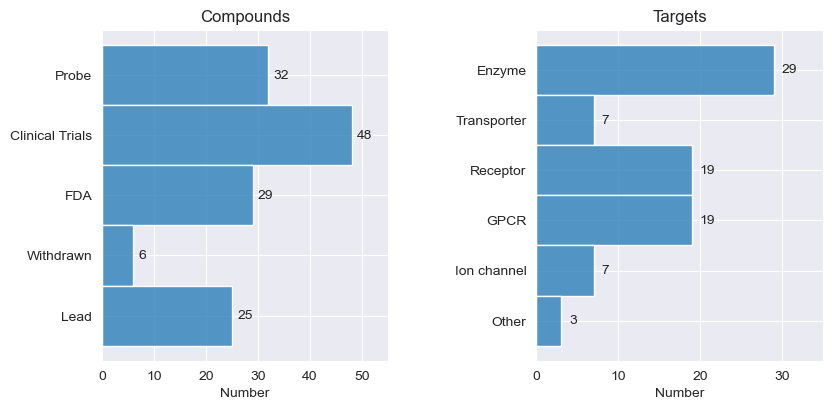

In [11]:
# compound & target category distributions
df_cpds = database[database.instance_type=='CPD'][['Id','instance_category']].drop_duplicates('Id')
df_tars = database.loc[database.instance_type=='TAR'][['Id','instance_category']].drop_duplicates('Id')


#plot
f, axs = plt.subplots(1,2,facecolor='none',figsize=(9,4))

sns.histplot(y=df_cpds.instance_category, ax=axs[0])
sns.histplot(y=df_tars.instance_category, ax=axs[1])

# Making graph more readable
convert = {'PROBE':'Probe', 'CLINICAL_TRIALS':'Clinical Trials', 'WITHDRAWN':'Withdrawn', 'LEAD':'Lead', 'FDA':'FDA',
           'enzyme':'Enzyme', 'transporter':'Transporter','Other_receptors':'Receptor', 'gpcr':'GPCR', 
           'Ionic Channel':'Ion channel', 'other_protein':'Other'}
ylimit = [55, 35]
f.tight_layout()

for i in range(2):
       new_names = [convert[name.get_text()] for  name in axs[i].get_yticklabels()]

       axs[i].set(xlim=(0,ylimit[i]), ylabel="",
              xlabel="Number",
              yticklabels = new_names)


       for p in axs[i].patches:
              width = p.get_width()    # get bar length
              axs[i].text(width + 1,       # set the text at 1 unit right of the bar
                     p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
                     f'{width:.0f}', # set variable to display, 2 decimals
                     ha = 'left',   # horizontal alignment
                     va = 'center')  # vertical alignment
              
axs[0].set_title('Compounds')
axs[1].set_title('Targets')


## TABLE

In [6]:
compounds = database[database['instance_type'] == 'CPD']
syn2 = compounds[compounds['answer'] == 'Synonym 2']
map_dic={f'C{row[0]}{row[1]}': len(row[-1]) for row in CPD_df.to_numpy()}
syn2['IUPAC string len']=syn2['Id'].map(map_dic)

val, db_list, N_syn2=[],[],[]
for db in databases:
        df=syn2
        df=df[df['database']==db]['IUPAC string len']
        #print(df.describe())
        cnt,mean,std=df.describe().loc[['count','mean','std']].round(1)
        db_list.append(db)
        N_syn2.append(round(cnt))
        if str(mean) == 'nan' or str(std) == 'nan':
                val.append(f'-')
        else:
                val.append(f'{mean}±{std}')



pd.DataFrame({
        'Database':db_list,
        'IUPAC string len': val,
        'N of Synonym2':N_syn2,
}).sort_values(by=['N of Synonym2'], ascending=False).reset_index(drop=True)#.to_csv('IUPAC.csv')


/var/folders/fb/3w9s6w2d3s9c5km783sbypd80000gn/T/ipykernel_34663/121585120.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn2['IUPAC string len']=syn2['Id'].map(map_dic)


,Database,IUPAC string len,N of Synonym2
0,Reaxys,77.6±33.5,54
1,ChEMBL,80.1±40.3,42
2,DrugBank,79.2±36.5,26
3,Santa Cruz,72.8±40.4,23
4,SelleckChem,87.0±39.1,21
5,MedChemExpress,86.4±40.4,14
6,Tocris,82.0±33.8,14
7,Guide to Pharmacology,96.5±62.9,11
8,Toronto Research Chemicals,70.0±61.8,11
9,Cayman,65.8±31.8,11


<b>Table description:</b>
<p>
<i>IUPAC string len</i> – mean ± standard deviation of IUPAC string length (number of symbols) for compound that was found by Synonym 2 (IUPAC)
</p>
<p>
<i>N Synonym2</i> – number of compounds found in this database by synonym2
</p>

* The best compound search results were obtained by synonym 1 and CAS number.
* Vendor databases do not contain structure search field except Toronto Research Chemicals but it also does not work well.
* Approximately half of participants had troubles in searching compounds in Probes and Drugs because of long lasting search(?)
* "Not found" helps us discover database fulness and/or instance annotations

## CPD search

In [14]:
def criterions_horizontal(section, isgood='Y', x_name='answer', save=False, 
                        presentation = False):
    section_questions = {
        'CPD_search':search_compounds,
        'CPD_biodata':biodata_compounds,
        'TAR_search':search_targets,
        'TAR_biodata':biodata_targets,
        'Assesment': {
            'POSITIVE':assesment,
            'NEGATIVE':assesmentNOT
                        }
    }

    palt = {
        'Academia' : 'tab:green',
        'Vendor' : 'tab:orange',
        'Closed' : 'tab:blue',
    }

    xlims = {
        'CPD_search':(0,125),
        'CPD_biodata':(0,130),
        'TAR_search': (0,85),
        'TAR_biodata':(0,80),
        }
    # Data initialization + sorting for proper order on graphs
    plot_data=database[database['isgood']==isgood]
    sort_dictionary = {cat:ind for ind,cat in enumerate(section_questions[section])}
    plot_data=plot_data[plot_data['section']==section].sort_values(by=[x_name], axis=0, key=lambda x:x.map(sort_dictionary))
    if x_name != 'answer':
        plot_data=plot_data[plot_data['answer']=='Synonym 1']

    def sns_plot(df, db, ax):
        ax.set_title(f'{db}', fontsize=16)
        df=df[df['database']==db]
        g=sns.histplot(data=df, y=x_name, bins=16,  ax=ax, hue='database_type', palette=palt, 
                       kde=False)
        
        
        g.legend([], [], frameon=False)
        g.set_ylabel('')
        g.set_xlabel('')
        g.set_xlim(xlims[section])

        if presentation:
            g.tick_params(axis='y',labelsize=16)
        elif presentation & (section == 'CPD_biodata'):
            g.tick_params(axis='y',labelsize=14)


        
        if 'CPD_search' == section:
            try:
                g.patches[5].set_alpha(0.8)
            except:
                pass
        elif 'TAR_search' == section:
            try:
                g.patches[4].set_alpha(0.8)
            except:
                pass
        
    #creating figure and axes
    fig, axs = plt.subplots(5,3,figsize=(10,15), sharey=True)
    axs[4,2].set_axis_off() # delete last empty axis
    fig.suptitle(section.upper().replace('_', ' '), fontsize=20)

    #Plot central graph over ALL databases
    axs[0,1].set_title(f'All databases')
    sns.histplot(data=plot_data, y=x_name, bins=16, ax=axs[0,1], kde=False, color='red')

    #Plot side graphs over reaxys and scifinder
    sns_plot(plot_data, db='Reaxys', ax=axs[0,0])
    sns_plot(plot_data, db='SciFinder', ax=axs[0,2])

    #Plot graphs that left
    for i, db in enumerate(databases[:-2]):
        sns_plot(df=plot_data, db=db, ax=axs[1+i//3 , i%3])


    
    fig.tight_layout()



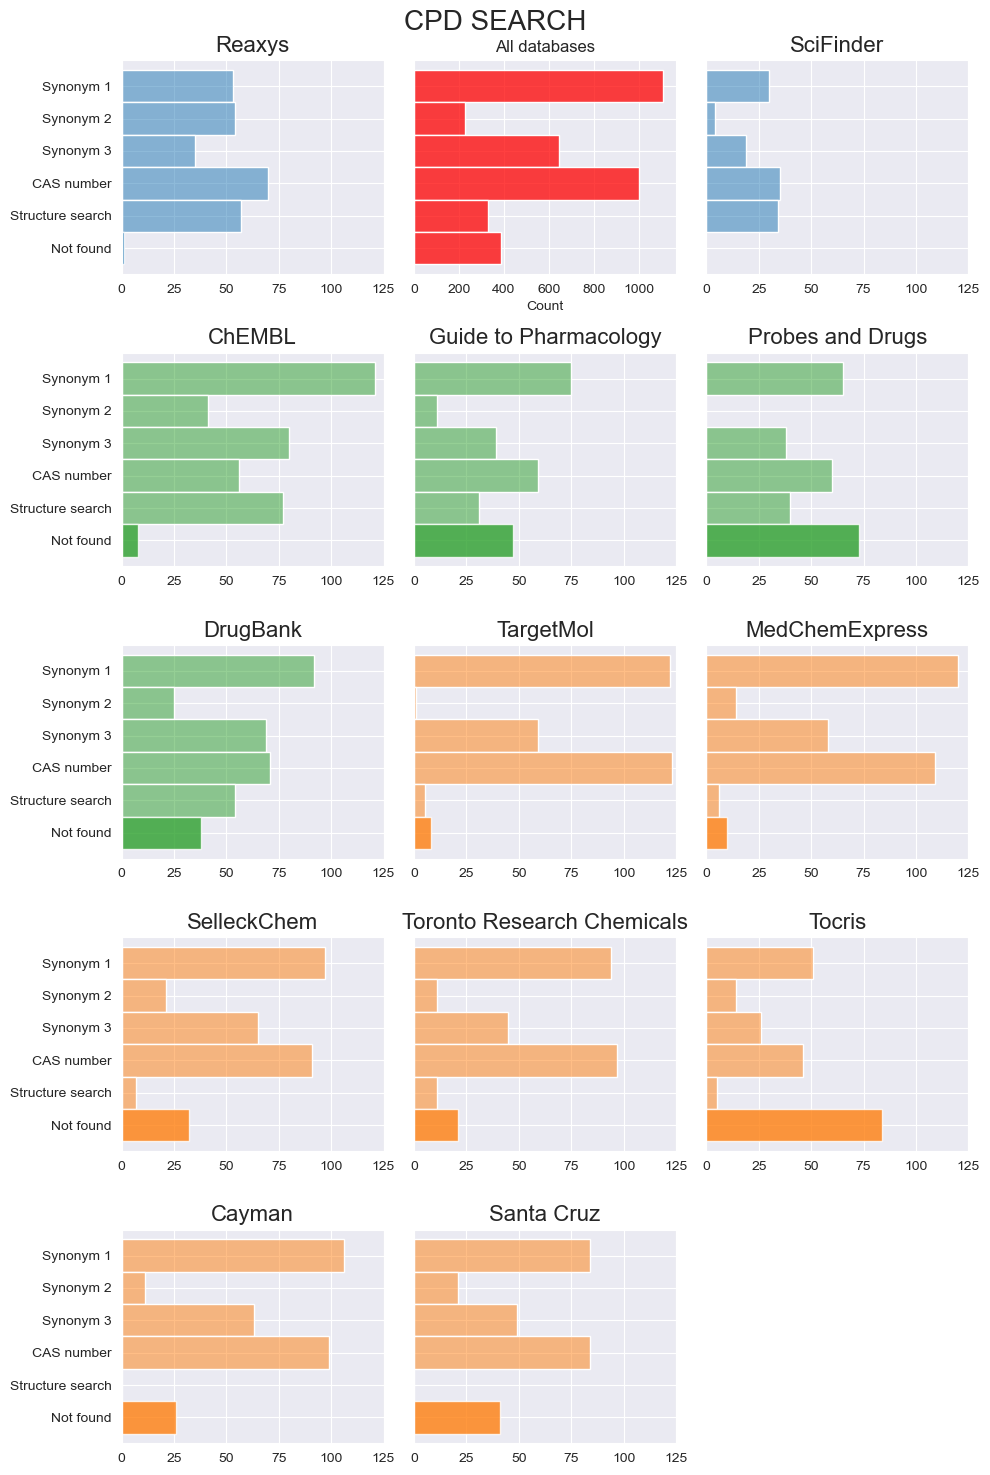

In [15]:
# Enter 'CPD_search', 'TAR_seach', 'CPD_biodata', 'TAR_biodata' to get corresponding plot
criterions_horizontal('CPD_search')


## Target search

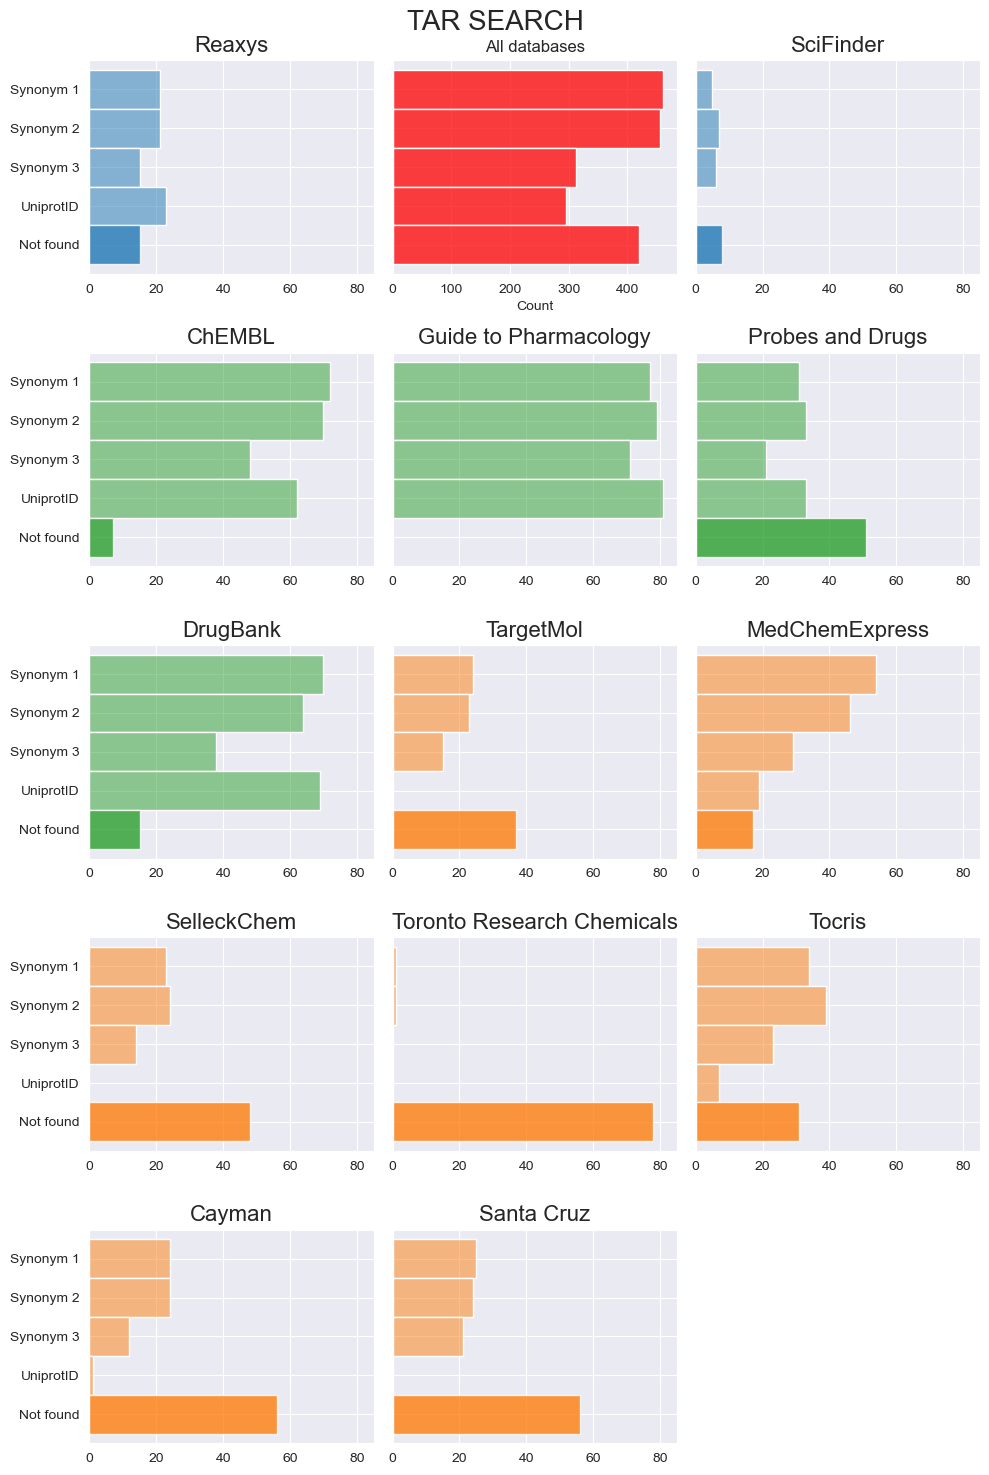

In [16]:
criterions_horizontal('TAR_search')

## Compound Biodata 

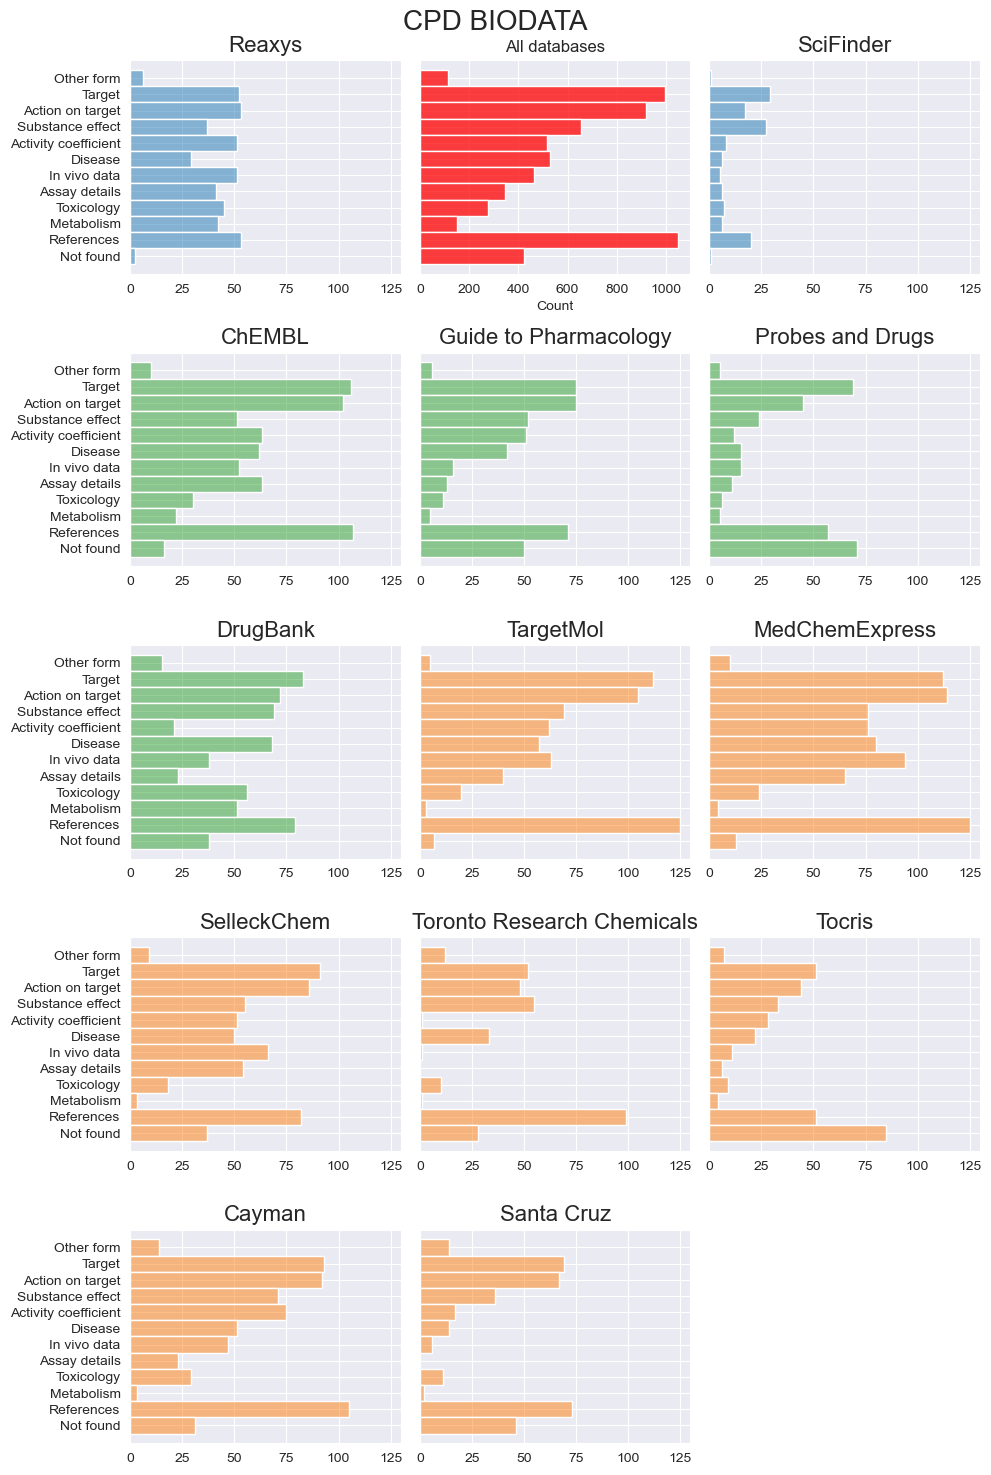

In [9]:
criterions_horizontal('CPD_biodata')

## Target Biodata 

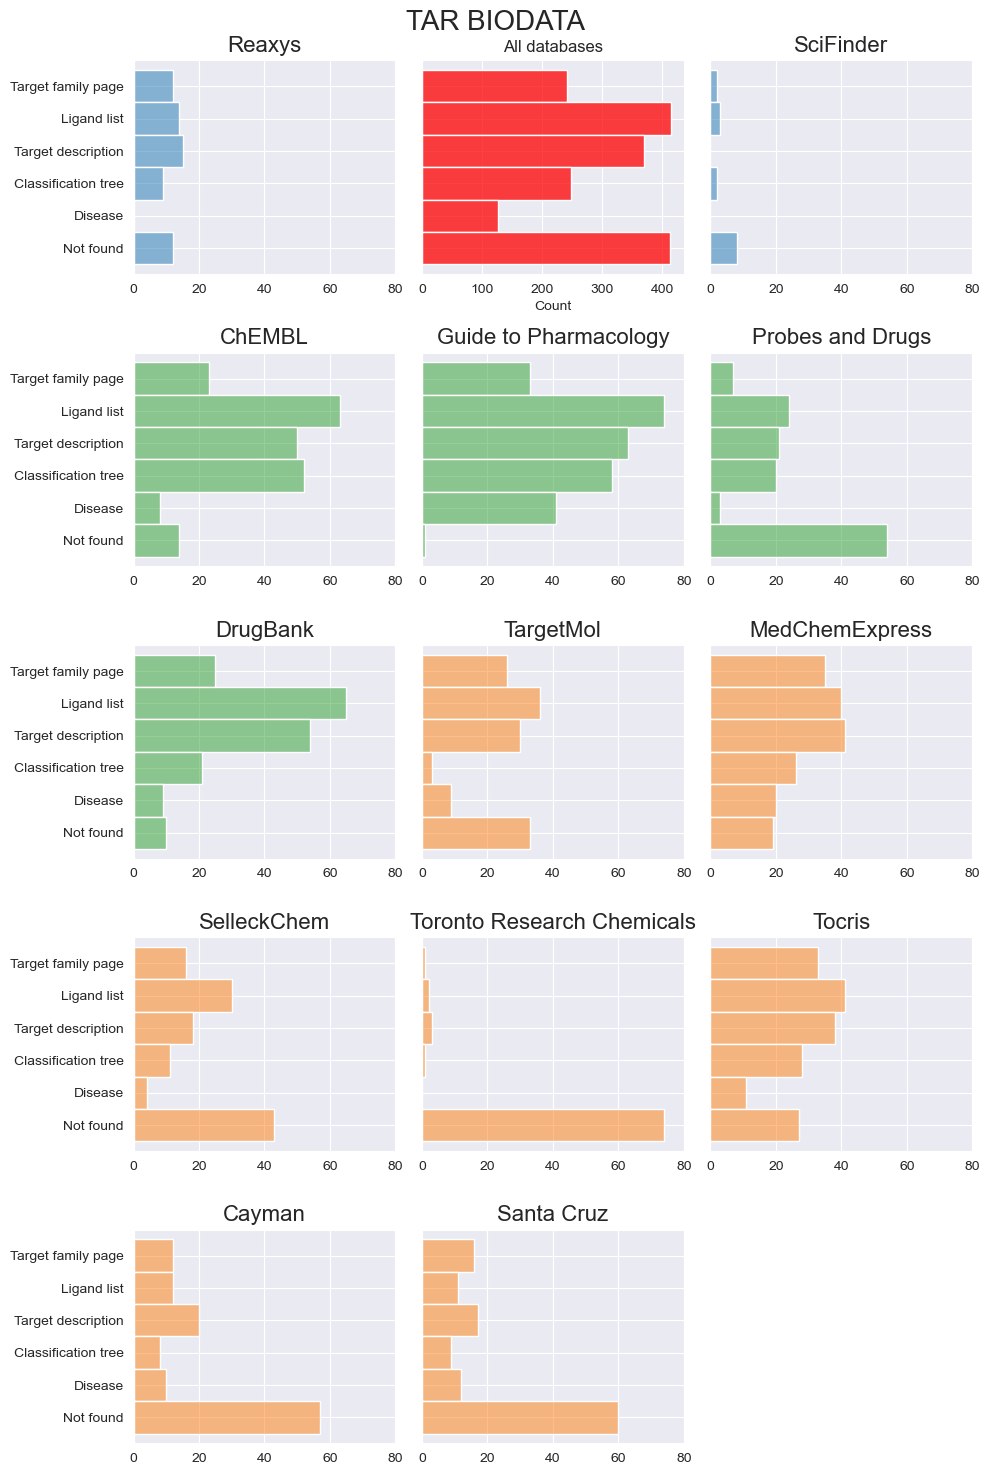

In [10]:
criterions_horizontal('TAR_biodata')

## Compound Patterns

[Text(0, 0.5, ''), Text(0.5, 0, 'Count')]

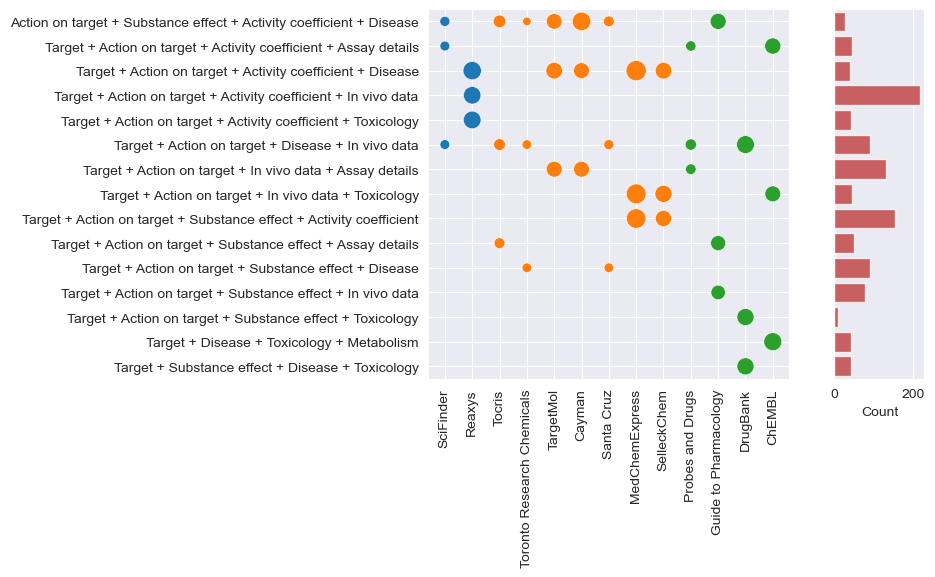

In [11]:
from itertools import combinations
from collections import Counter

class PatternAnalysis:
    def __init__(self,grams_range, top_n, perc=0.75, remove_word=None) -> None:
        self.grams_range = grams_range
        self.top_n = top_n
        self.patterns = {}
        self.df_patterns = {}
        self.remove_word = remove_word

        cpd_biodata = ['Action on target', 'Target', 'References', 'Activity coefficient', 'Assay details', 'Disease',
        'In vivo data', 'Substance effect', 'Toxicology', 'Metabolism', 'Other form', 'Not found']
        
        tar_biodata=['Target family page','Ligand list','Target description',
                     'Classification tree','Disease','Not found']


        self.ans2can = {ans:ans.replace(' ','') for ans in cpd_biodata+tar_biodata}
        self.can2ans = {ind:ans for ans,ind in self.ans2can.items()}
        
    def _calculate(self, corpus):
        freq_dist = Counter()

        for sentence in corpus:
            words = sentence.split(' ')
            for n in range(self.grams_range[0], self.grams_range[1]+1,1):
                freq_dist.update(Counter(combinations(words,n)))

        sorted_ngrams = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)
        return sorted_ngrams
    

    def _printTopResults(self,db_name, N):
        sorted_ngrams = self.patterns[db_name]
        for bigram, freq in sorted_ngrams[:N]:
            bigram = [self.can2ans[bg] for bg in bigram]
            print(" + ".join(bigram), freq)

        return self.df_patterns[db_name]
        
    def fit(self, corpus, db_name):
        if self.remove_word != None:
            corpus = [sentence.replace(' '+ self.remove_word, '') for sentence in corpus]

        sorted_ngrams = self._calculate(corpus)#[:20]
        self.patterns[db_name] = sorted_ngrams
        n=self.top_n

        self.df_patterns[db_name] = pd.DataFrame({
                            'X':[freq for _, freq in sorted_ngrams], 
                            'Y':[" + ".join([self.can2ans[bg] for bg in bigram]) for bigram, freq in sorted_ngrams]
                                })
        
    def __dataForPlot(self):
        # Data creation
        dataframes = []
        df = pd.DataFrame(self.df_patterns['All_databases'][:self.top_n])
        df['Database'] = 'All_databases'
        for db in databases:
            df = pd.DataFrame(self.df_patterns[db][:self.top_n])
            df['Database'] = db
            dataframes.append(df)
        all_info = pd.concat(dataframes, axis = 0)

        grouped_df = all_info.groupby(['Y','Database']).agg({'X':'sum'}).reset_index()

        #If not all databases in df. Add zero rows for db's
        if grouped_df.Database.unique().shape[0] != 13:
            db_left = [db for db in databases if db not in grouped_df.Database.unique()]
            df_zero = pd.DataFrame({'Y': ['None' for i in range(len(db_left))],#grouped_df.Y[0]
                                    'X': [0 for i in range(len(db_left))],
                                    'Database': db_left
                                })
            grouped_df = pd.concat([grouped_df,df_zero], axis=0)

        # Adding database type and sorting
        converter_df = pd.DataFrame(database[['database', 'database_type']].drop_duplicates(['database', 'database_type']))
        db2type = {db:db_type for i,(db, db_type) in converter_df.iterrows()}
        grouped_df['type'] = grouped_df.Database.apply(lambda db_name: db2type[db_name])
        order = {v: i for i, v in enumerate(['Closed', 'Vendor', 'Academia'])}
        result_df = grouped_df.sort_values(by='type',key=lambda x: x.map(order))
        return result_df
    
    def get_data(self):
        return self.__dataForPlot()

    def plot(self, ax):
        sns.scatterplot(data=self.__dataForPlot(), x='Database', y='Y', size='X', hue='type' ,ax=ax, 
                        palette=['C0','C1', 'C2'])
                        #palette=sns.color_palette("summer", as_cmap=True))#sns.color_palette("coolwarm", as_cmap=True))
        ax.tick_params(axis='x', rotation=90)
        ax.get_legend().remove()
        ax.set(ylabel='', xlabel='')

        return[i.get_text() for i in ax.get_yticklabels()]

     
patterns_compounds = PatternAnalysis((4,7), top_n=3, remove_word='References')
allDBCorpus = []
for db_name in database.database.unique():
    DB = database[(database.isgood == 'Y') & (database.database == db_name) & (database.section == 'CPD_biodata')]
    corpus = []
    for i,idx in enumerate(DB.Id.unique()):
        processed_answers = [patterns_compounds.ans2can[item] for item in DB[DB.Id == idx].answer.to_list()]
        corpus.append(' '.join(processed_answers))

    allDBCorpus += corpus
    patterns_compounds.fit(corpus, db_name)
patterns_compounds.fit(allDBCorpus, 'All_databases')


f,ax = plt.subplots(1,2, sharey=True,gridspec_kw={'width_ratios': [4, 1]})
lbls = patterns_compounds.plot(ax[0])
for collection in ax[0].collections:
    sizes = collection.get_sizes()
    collection.set_sizes(sizes ** 1.25)




dtx = patterns_compounds.get_data().groupby(['Y']).agg({'X':'sum'}).reset_index()
order = {v: i for i, v in enumerate(lbls)}
dtx = dtx.sort_values(by='Y',key=lambda x: x.map(order))
sns.barplot(data=dtx, y='Y', x='X', color='C3', alpha=0.8, ax=ax[1])
ax[1].set(ylabel='',
          xlabel = 'Count')

# Target Patterns

[Text(0, 0.5, ''), Text(0.5, 0, 'Count')]

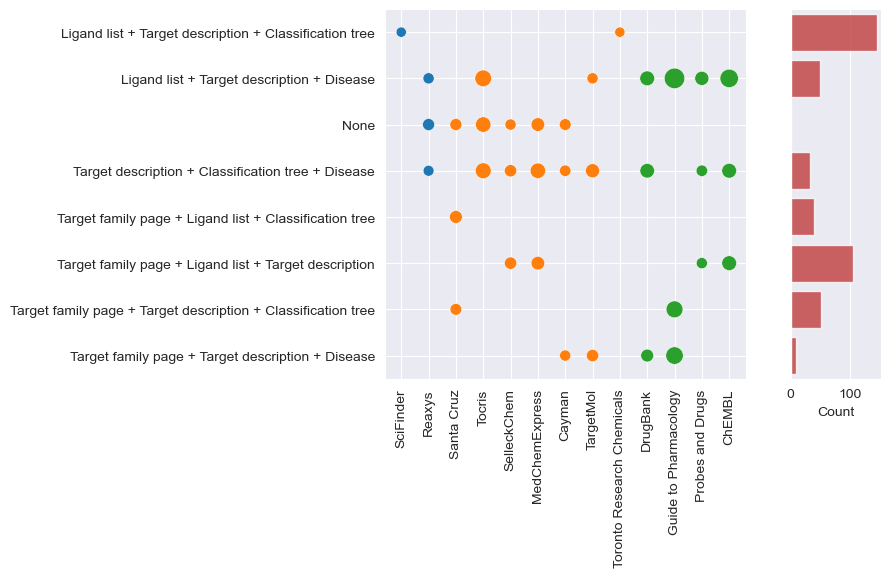

In [12]:
patterns_targets = PatternAnalysis((3,5), top_n=3, remove_word='Target family page')
allDBCorpus = []
for db_name in database.database.unique():
    DB = database[(database.isgood == 'Y') & (database.database == db_name) & (database.section == 'TAR_biodata')]
    corpus = []
    for i,idx in enumerate(DB.Id.unique()):
        processed_answers = [patterns_targets.ans2can[item] for item in DB[DB.Id == idx].answer.to_list()]
        corpus.append(' '.join(processed_answers))

    allDBCorpus += corpus
    patterns_targets.fit(corpus, db_name)
patterns_targets.fit(allDBCorpus, 'All_databases')

f,ax = plt.subplots(1,2, sharey=True,gridspec_kw={'width_ratios': [4, 1]})
lbls = patterns_targets.plot(ax[0])
for collection in ax[0].collections:
    sizes = collection.get_sizes()
    collection.set_sizes(sizes * 3)

dtx = patterns_targets.get_data().groupby(['Y']).agg({'X':'sum'}).reset_index()
order = {v: i for i, v in enumerate(lbls)}
dtx = dtx.sort_values(by='Y',key=lambda x: x.map(order))
sns.barplot(data=dtx, y='Y', x='X', color='C3', alpha=0.8, ax=ax[1])
ax[1].set(ylabel='',
          xlabel = 'Count')

# ASSESSMENT

/var/folders/fb/3w9s6w2d3s9c5km783sbypd80000gn/T/ipykernel_39583/501751611.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds = ds.append(df2, ignore_index = True)


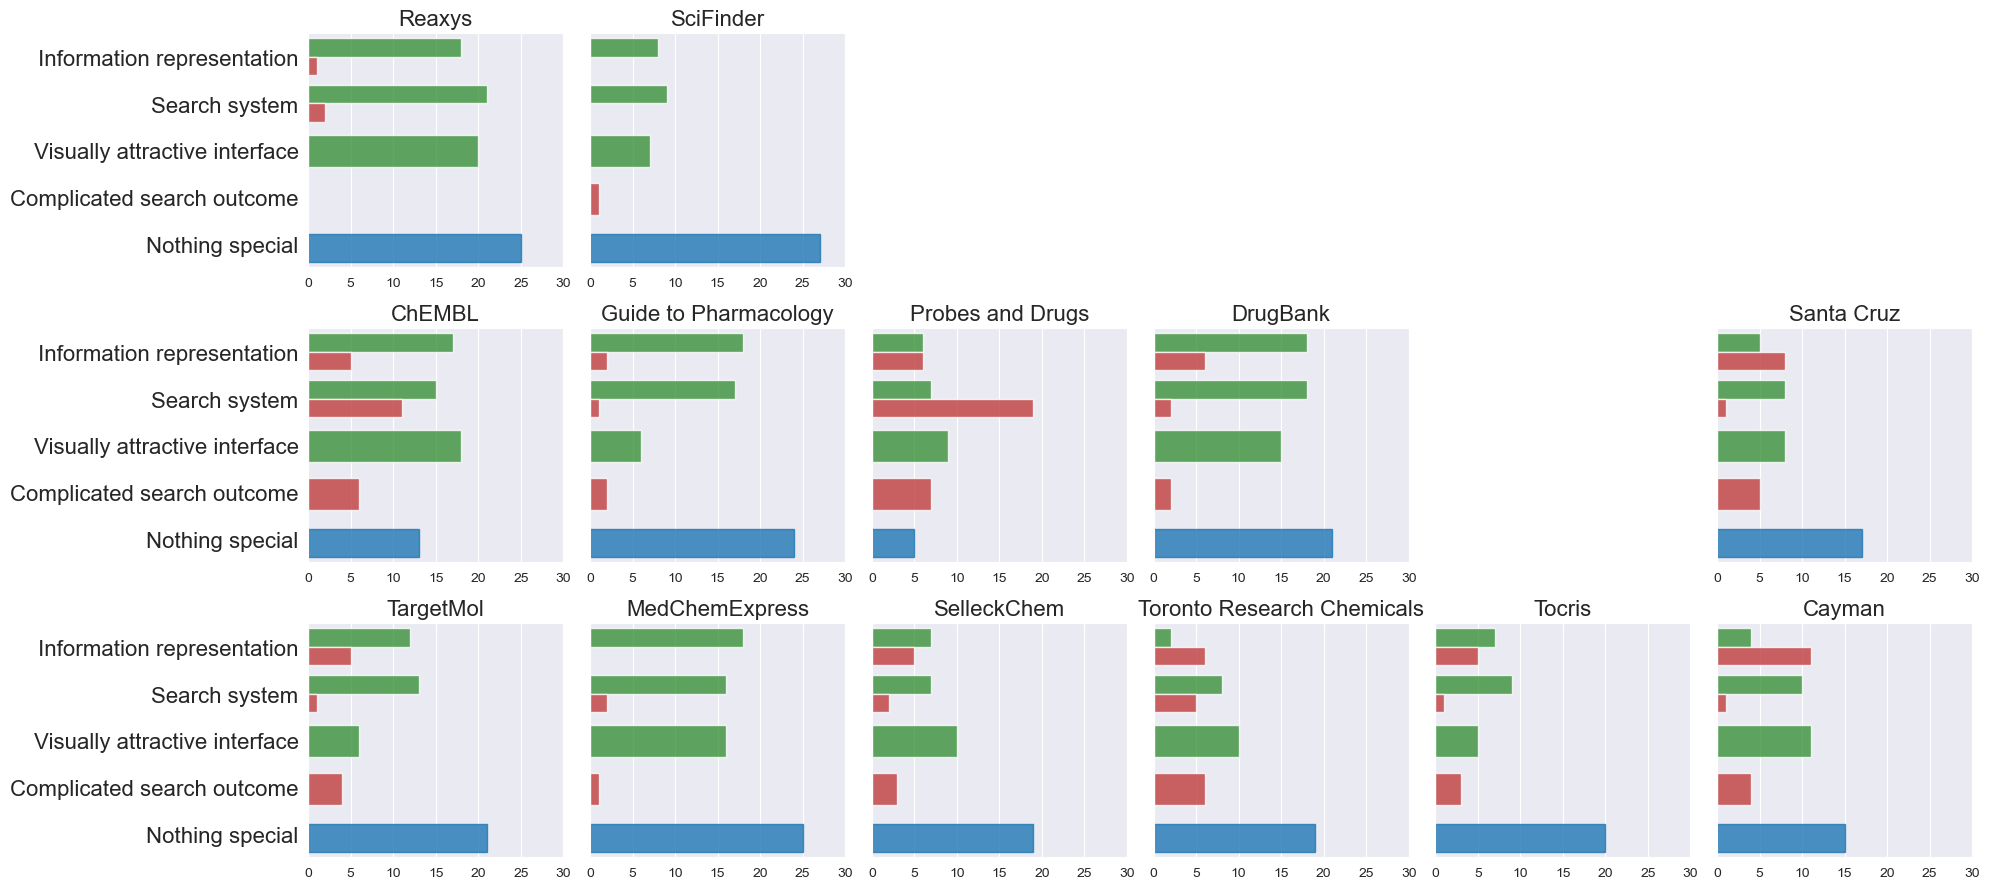

In [17]:
import numpy as np
sort_dictionary = {'Information representation':0,
                   'Search system':1,
                   'Visually attractive interface':2,
                   'Complicated search outcome':3,
                   'Nothing special':4 }
def create_data(db_name):
    df = pd.DataFrame(database[(database.section == 'Assessment') & (database.database == db_name)][['instance_category',
                                                                                                    'participant',
                                                                                                    'database',
                                                                                                    'answer',
                                                                                                    'database_type']])

    conv_asses = {'Information representation*':'Information representation', 
                'Search system**':'Search system',
                'Slow search':'Search system',
                'Nothing special':'Nothing special',
                'Visually attractive interface':'Visually attractive interface',
                'Complicated search outcome**':'Complicated search outcome',
                }
    df['test'] = [conv_asses[ans] for ans in df.answer]   
    dp = dict(df[df.instance_category == 'POSITIVE'].test.value_counts())
    dn = dict(df[df.instance_category == 'NEGATIVE'].test.value_counts())
    dfs = [pd.DataFrame({'ANS':list(dp.keys()),'count':list(dp.values()), 'Type':['Positive' for i in range(len(dp))]}),
        pd.DataFrame({'ANS':list(dn.keys()),'count':list(dn.values()), 'Type':['Negative' for i in range(len(dn))]})
    ]
    ds=pd.concat(dfs, axis=0, ignore_index=True)
    
    ix=ds[ds.ANS == 'Nothing special'].index
    ds.loc[ix,'Type'] = 'Positive'
    ds.loc[ix[0], 'count'] += ds.loc[ix[1], 'count']
    ds=ds.drop(ix[0])
    if db_name == 'Reaxys':
        df2 = {'ANS': 'Complicated search outcome', 'count': 0, 'Type': 'Positive'}
        ds = ds.append(df2, ignore_index = True)
    return ds.sort_values(by=['ANS'], axis=0, key=lambda x:x.map(sort_dictionary))

def plot(db_name,axis):
    sns.barplot(data=create_data(db_name), x='count', y='ANS',  hue='Type',
                palette=["C2", "C3",'C0'], ax=axis,  alpha=0.8)
    axis.set(ylabel="",xlabel="", title='Database: '+db_name,
             xticks=(np.arange(0, 30+1, 5)), xlim=(0,30)
                    )
    axis.get_legend().remove()
    axis.set_title(db_name, fontsize=16)
    axis.tick_params(axis='y',labelsize=16)

    for ind,p in enumerate(axis.patches):
        if ind ==4: # Noth special
            p.set_color('#1f77b4')
            p.set_alpha(0.8)
            w,y=p.get_height(), p.get_y()
            p.set_height(w*1.5)
            p.set_y(y*1.05)

        elif ind ==8 : # Search outcome 
            #p.set_color('#1f77b4')
            p.set_alpha(0.8)
            w,y=p.get_height(), p.get_y()
            p.set_height(w*1.7)
            p.set_y(y*0.9)
        elif ind ==2: # Attractive interface
            #p.set_color('#1f77b4')
            p.set_alpha(0.8)
            w,y=p.get_height(), p.get_y()
            p.set_height(w*1.7)
            p.set_y(y*1.05)


#creating figure and axes
def create_plots(presentation=False):

    if not presentation:

        fig, axs = plt.subplots(5,3,figsize=(10,15), sharey=True)
        axs[4,2].set_axis_off() # delete last empty axis
        fig.suptitle('ASSESSMENT', fontsize=20)
        

        #Plot central graph over ALL databases
        #axs[0,].set_axis_off() 
        #Plot side graphs over reaxys and scifinder
        plot('Reaxys', axs[0,0])
        plot('SciFinder', axs[0,2])

        #Plot graphs that left
        for i, db_name in enumerate(rd.databases[:-2]):
            plot(db_name, axs[1+i//3 , i%3])

        fig.tight_layout()

    else:
        fig, axs = plt.subplots(3,6,figsize=(20,9), sharey=True)
        axs[0,5].set_axis_off() # delete last empty axis
        axs[0,2].set_axis_off() # delete last empty axis
        axs[0,4].set_axis_off() # delete last empty axis
        axs[0,3].set_axis_off() # delete last empty axis
        axs[1,4].set_axis_off() # delete last empty axis
        

        
        #Plot COMMERCIAL
        plot('Reaxys', axs[0,0])
        plot('SciFinder', axs[0,1])


        #Plot ACADEMIA
        plot('ChEMBL', axs[1,0])
        plot('Guide to Pharmacology', axs[1,1])
        plot('Probes and Drugs', axs[1,2])
        plot('DrugBank', axs[1,3])

        #Plot graphs that left
        plot('Santa Cruz', axs[1,-1])
        for i, db in enumerate(databases[4:-3]):
            plot(db, axs[2+i//6 , i%6])
        fig.tight_layout()


create_plots(True)